In [1]:
from pyInfinityFlow.InfinityFlow_Utilities import marker_finder

In [2]:
import os
import pandas as pd
import numpy as np
import re
import scanpy as sc
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir("/data/salomonis2/LabFiles/Kyle/Analysis/2023_06_12_tea_seq_atac_processing/")

In [3]:
## Helper functions
def pearson_corr_df_to_df(df1, df2):
    norm1 = df1 - df1.mean(axis=0)
    norm2 = df2 - df2.mean(axis=0)
    sqsum1 = (norm1**2).sum(axis=0)
    sqsum2 = (norm2**2).sum(axis=0)
    return((norm1.T @ norm2) / np.sqrt(sqsum1.apply(lambda x: x*sqsum2)))


def marker_finder(input_df, groups):
    """
    Function to find pearson correlation coefficient values and p-values for 
    the given data and groups for groups to test. The function will perform a 
    Pearson correlation of the input_df feature values to an "idealized" 
    group specific expression vector, where each observation in a given group
    is set to a value of 1, and the observations in other groups are set to 0.
    Arguments
    ---------
    input_df : pandas.DataFrame
        DataFrame with observations as index and features as columns (Required)
    
    groups : list[str]
        List-like of specified groups corresponding to observations from the 
        input_df. The order of groups should match the order in input_df.index
        (Required)
    Returns
    -------
    tuple (pandas.DataFrame, pandas.DataFrame)
        The first item in the tuple is a pandas.DataFrame containing the pearson
        correlation coefficient values for each marker to the idealized vector
        for each cluster.
        The second item is also a pandas.DataFrame, but contains the p-values 
        for each comparison.
    """
    ideal_vectors = pd.get_dummies(groups)
    ideal_vectors.index = input_df.index.values
    degrees_f = input_df.shape[0] - 2
    r_df = pearson_corr_df_to_df(input_df, ideal_vectors)
    t_df = r_df*np.sqrt(degrees_f) / np.sqrt(1-(r_df**2))
    p_df = t_df.applymap(lambda x: stats.t.sf(abs(x), df=degrees_f)*2)
    return((r_df, p_df))

In [4]:
# Read in the ATAC data
path_atac_data = "output/tea_r7_pseudobulk_from_pmat/"

peaks = pd.read_table(\
    os.path.join(path_atac_data, "r7_tea_cluster_peak_set_with_tss.bed"),
    header=None)
peaks.columns = ["chr", "start", "end", "name", "score", "strand"]

atac_counts = pd.read_csv(\
    os.path.join(path_atac_data, "r7_tea_pbulk_cpm_from_binary_pmat.csv"))

atac_counts

,IG2-proNeu1,ST-HSC,HSCP-HPC_Tk1,IG2-MP,MPP5-Egr1,HSCP-ERP1,MPP4-Hlf,MDP-Cpa3,MPP4-Nkx2-3,eHSC,...,immNeu-2,CHILP,alphaLP,immNeu-3,pre-cDC1_Xcr1,cMoP-Mki67,cKit-Mast,CLP2,pre-cDC2,cMoP-S100a4
0,0.406455,0.000000,0.103804,0.284799,0.000000,0.217408,0.00000,0.291983,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.310092,0.000000,0.070026,0.051544,0.000000,0.166050,0.07199,0.489317,0.091988,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.387690,0.041731,0.035438,0.368475,0.058635,0.217408,0.00000,0.343904,0.091988,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.443267,0.000000,0.000000,0.408561,0.058635,0.000000,0.00000,0.238124,0.000000,0.364004,...,0.0,0.0,0.0,0.0,0.0,3.881428,0.0,0.0,0.0,0.0
4,0.443267,0.000000,0.103804,0.485538,0.058635,0.112795,0.00000,0.238124,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
757536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
757537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
757538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [5]:
# Filter to only the clusters with at least 25 cells
atac_r7_vcounts = pd.read_csv(\
    os.path.join(path_atac_data, "r7_cell_counts_tea_seq_merged_captures.csv"),
    index_col=0, header=None).iloc[:,0]
atac_r7_vcounts.index.name = None

clusters_to_use = atac_r7_vcounts[atac_r7_vcounts > 25].index.values

clusters_to_use

array(['IG2-proNeu1', 'ST-HSC', 'HSCP-HPC_Tk1', 'IG2-MP', 'MPP5-Egr1',
       'HSCP-ERP1', 'MPP4-Hlf', 'MDP-Cpa3', 'MPP4-Nkx2-3', 'eHSC',
       'HSCP-HPC_Hist1h2af', 'pre-MultiLin-1', 'MDP-Irf8', 'MEP',
       'MultiLin-2_F13a1', 'LT-HSC_Mllt3', 'eHSC-Pcna', 'HSCP-HPC_Cenpf',
       'HSCP-MKP', 'MPP5-Flt3', 'MultiLin-1', 'pre-MultiLin-2', 'BMCP',
       'proNeu-1', 'ML-cell-cycle', 'ERP1', 'MultiLin-1_MEP',
       'MultiLin-2_Ms4a3', 'CLP1-Rrm2', 'MKP', 'HSC-Mac_Fcna', 'CD127-MP',
       'ETP-CC-4', 'Baso', 'MultiLin-1_preBMCP', 'ERP2', 'Eosinophils',
       'ML-Mast', 'DN4-DP-trans_Hist1h3c', 'CLP1-Hist1h1c',
       'pre-cDC1_Egfl8', 'ST-HSC-CC-Mac-1', 'proNeu-1-ADT', 'immNeu-1',
       'MPP4-Ccr9', 'Ebf1+ proB_Hmga2', 'ETP-A-0'], dtype=object)

In [6]:
# Read in the CITE-seq RNA counts
path_cite_data = "/data/salomonis2/LabFiles/Kyle/Data/2021_11_mouse_optimized_cite_seq/processed_files/"

adata_cite = sc.read(os.path.join(\
    path_cite_data, 
    "cite_seq_adata_rna_combined.h5ad"))
print("Computing CPTT normalized scRNA-seq from CITE-seq...")
adata_cite.X = np.log2((10000 * (adata_cite.X.T / \
    adata_cite.X.sum(axis=1).T).T) + 1)
cite_cell_anno = pd.read_csv(os.path.join(\
    path_cite_data, 
    "cite_seq_cell_annotations.csv"))
cite_cell_anno.index = cite_cell_anno["Cell_Barcode"].values

cite_cell_anno

Computing CPTT normalized scRNA-seq from CITE-seq...


,Cell_Barcode,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,identity,source,sctri_cite
AS_3CITE_Kit_AAACCCAAGAGAACCC-1,AS_3CITE_Kit_AAACCCAAGAGAACCC-1,cite,4595,31300.0,766.0,2.447284,Kit,other,ERP4--Ex
AS_3CITE_Kit_AAACCCAAGGACTAAT-1,AS_3CITE_Kit_AAACCCAAGGACTAAT-1,cite,2852,12667.0,266.0,2.099945,Kit,other,MultiLin-2_ML-c9--RNA
AS_3CITE_Kit_AAACCCACAACCAATC-1,AS_3CITE_Kit_AAACCCACAACCAATC-1,cite,5128,46822.0,1297.0,2.770065,Kit,other,ERP2_Kit-c14--RNA
AS_3CITE_Kit_AAACCCACAAGGCAAC-1,AS_3CITE_Kit_AAACCCACAAGGCAAC-1,cite,3114,38088.0,554.0,1.454526,Kit,other,ERP2--Ex
AS_3CITE_Kit_AAACCCACAGATTTCG-1,AS_3CITE_Kit_AAACCCACAGATTTCG-1,cite,2209,6442.0,160.0,2.483701,Kit,other,Ebf1+_proB_CD127-c2--RNA
...,...,...,...,...,...,...,...,...,...
AS_CITE_CD127_TTTGTTGGTCGTCGGT-1,AS_CITE_CD127_TTTGTTGGTCGTCGGT-1,cite,4356,26022.0,548.0,2.105910,CD127,other,cMoP--Ex
AS_CITE_CD127_TTTGTTGTCAAGGTGG-1,AS_CITE_CD127_TTTGTTGTCAAGGTGG-1,cite,4271,26772.0,287.0,1.072016,CD127,other,MP_ML-c12--RNA
AS_CITE_CD127_TTTGTTGTCCAACTGA-1,AS_CITE_CD127_TTTGTTGTCCAACTGA-1,cite,2816,9932.0,136.0,1.369311,CD127,other,CLP2_CD127-c10--RNA
AS_CITE_CD127_TTTGTTGTCCTTTGAT-1,AS_CITE_CD127_TTTGTTGTCCTTTGAT-1,cite,4817,28690.0,244.0,0.850471,CD127,other,MDP--Ex


In [7]:
# Make pseudobulk RNA counts from cite clusters
print("Computing RNA centroids...")
shared_cells_cite = np.intersect1d(cite_cell_anno.index.values, 
    adata_cite.obs.index.values)
cite_cell_anno = cite_cell_anno.loc[shared_cells_cite]
cite_rna = {}
for tmp_cluster in cite_cell_anno["sctri_cite"].unique():
    print("\t{}...".format(tmp_cluster))
    tmp_barcodes = cite_cell_anno.loc[\
        cite_cell_anno["sctri_cite"] == tmp_cluster].index.values
    cite_rna[tmp_cluster] = pd.Series(np.asarray(\
            adata_cite[tmp_barcodes].X.mean(axis=0)).reshape(-1),
            index=adata_cite.var.index.values)

cite_rna = pd.DataFrame(cite_rna)
cite_rna = cite_rna.drop("Unknown", axis=1)
map_r7_names = pd.read_csv(os.path.join(\
    path_cite_data, 
    "map_r7-v1_to_r7-v2_names.csv"))
map_r7_names_v1_to_v2 = pd.Series(\
    map_r7_names["R7_V2"].values,
    index = map_r7_names["R7_V1"].values)

cite_rna = cite_rna.rename(map_r7_names_v1_to_v2, axis=1)
cite_rna = cite_rna[clusters_to_use]

Computing RNA centroids...
	ERP4--Ex...
	MultiLin-2_ML-c9--RNA...
	ERP2_Kit-c14--RNA...
	ERP2--Ex...
	Ebf1+_proB_CD127-c2--RNA...
	proNeu-1_1-4--ADT...
	Unknown...
	preNeu-2_1-8--ADT...
	cMoP_ML-c15--RNA...
	immNeu_Kit-c3--RNA...
	MP--Ex...
	proNeu-2_Kit-c4--RNA...
	Ebf1+_proB--Ex...
	ML_ERP1_ML-c4--RNA...
	MDP--Ex...
	preNeu-3_Kit-c2--RNA...
	ERP4_Kit-c13--RNA...
	preNeu-3_2-3--ADT...
	immNeu_2-5--ADT...
	preNeu-1_Kit-c5--RNA...
	immNeu_Kit-c1--RNA...
	cMoP--Ex...
	neoHPC_Myc--Ex...
	Bcl11b+_preETP--Ex...
	ML_Multi-Lin-2_HSC-c7--RNA...
	Ebf1+_proB_CD127-c8--RNA...
	IG2-proNeu1_ML-c14--RNA...
	ML_Mast--Ex...
	ML_cell_cycle_ML-c5--RNA...
	HSC-HPC-Cenpf_HSC-c12--RNA...
	MultiLin-2_ERP_ML-c10--RNA...
	ML_MDP_ML-c13--RNA...
	proNeu-1--Ex...
	SiglecH-Ly6C-pre-DC--Ex...
	HSC-HPC-Mki67--Ex...
	Pro-B_CD127-c3--RNA...
	precursor_B_cell_5-2--ADT...
	CLP1_CD127-c5--RNA...
	ML_MultiLin-1_ML-c8--RNA...
	ETP-A-0-Ccl4--Ex...
	ETP-CC-4-Ung--Ex...
	eHSC-Pcna_HSC-c9--RNA...
	MPP4-Flt3_HSC-c6--RNA...
	MP

In [8]:
# Pull out the TSS positions from peaks
tss_loci = peaks.loc[peaks["name"].str.contains("TSS:")].copy()
tss_loci["gene"] = [i.split(":")[-1] for i in tss_loci["name"].values]
tss_loci = tss_loci[["gene", "chr", "start"]]
tss_loci["start"] = tss_loci["start"] + 500
tss_loci

,gene,chr,start
114,Xkr4,chr1,3671497
373,Mrpl15,chr1,4785709
382,Lypla1,chr1,4807822
404,Tcea1,chr1,4857813
442,Rgs20,chr1,5018734
...,...,...,...
751317,Uty,chrY,1245690
751334,Ddx3y,chrY,1286628
751345,Usp9y,chrY,1459781
757491,Gm21860,chrY,90755466


In [9]:
# Filter to expressed genes that have TSS annotation
genes_to_use = cite_rna.loc[cite_rna.sum(axis=1) > 0].index.values
genes_to_use = np.intersect1d(\
    genes_to_use,
    tss_loci["gene"].values)
len(genes_to_use)

15573

In [10]:
# Read in the TADs
tads = pd.read_table("input/GSE119347_BMHSC_TADs/GSE119347_BMHSC_TADs_mm10_liftover.bed", 
    header=None)
tads.columns = ["chr", "start", "end", "name", "score"]
tads

,chr,start,end,name,score
0,chr10,5881540,7341540,chr10:3005001-4465000,1
1,chr10,5321540,5881540,chr10:4465001-5025000,1
2,chr10,4401540,5321540,chr10:5025001-5945000,1
3,chr10,3961540,4401540,chr10:5945001-6385000,1
4,chr10,3100000,3961540,chr10:6385001-7265000,1
...,...,...,...,...,...
2511,chrX,162907068,164497068,chrX:159345001-160935000,1
2512,chrX,164497068,166137068,chrX:160935001-162575000,1
2513,chrX,166137068,167267068,chrX:162575001-163705000,1
2514,chrX,167267068,168537068,chrX:163705001-164975000,1


In [11]:
path_output = "output/correlate_tea_atac_to_cite_rna_across_r7_clusters/"
test_name = "peak_to_gene_correlation_within_tads"

list_sig_files = os.listdir(os.path.join(path_output, test_name, "significant_connections"))

test = pd.read_csv(os.path.join(\
    path_output,
    test_name,
    "significant_connections",
    list_sig_files[0]),
    index_col=0)

sig_conns_df = pd.concat([pd.read_csv(os.path.join(\
    path_output,
    test_name,
    "significant_connections",
    i), index_col=0) for i in list_sig_files])

sig_conns_df


,gene,peak,r,p
23,2900089D17Rik,chr5:144026531-144027531,0.689254,8.454730e-08
32,2900089D17Rik,chr5:144040343-144041343,0.466576,9.470651e-04
59,2900089D17Rik,chr5:144099829-144100829,0.503086,3.131146e-04
60,2900089D17Rik,chr5:144099935-144100935,0.503974,3.043190e-04
72,2900089D17Rik,chr5:144125641-144126641,0.551664,5.836859e-05
...,...,...,...,...
335,Lypd6,chr2:50174219-50175219,0.538422,9.466431e-05
337,Lypd6,chr2:50177952-50178952,0.784699,6.704674e-11
339,Lypd6,chr2:50188001-50189001,0.485716,5.383332e-04
352,Lypd6,chr2:50265457-50266457,0.494948,4.050589e-04


In [12]:
print("Number of unique genes in sig_conns_df: {}".format(\
    len(sig_conns_df["gene"].unique())))
print("Number of unique peaks in sig_conns_df: {}".format(\
    len(sig_conns_df["peak"].unique())))

Number of unique genes in sig_conns_df: 13208
Number of unique peaks in sig_conns_df: 116378


In [13]:
seg_atac = atac_counts[cite_rna.columns.values].copy()
seg_atac.index = peaks["chr"] + ":" + \
    peaks["start"].astype(str) + "-" + \
    peaks["end"].astype(str)
seg_atac = seg_atac.loc[sig_conns_df["peak"].unique()]
seg_atac = seg_atac.loc[~pd.Series(seg_atac.index.values).duplicated().values]
seg_atac.shape

(116378, 47)

In [20]:
r_df_tot = pearson_corr_df_to_df(\
    cite_rna.loc[sig_conns_df["gene"].unique()].T,
    seg_atac.T)

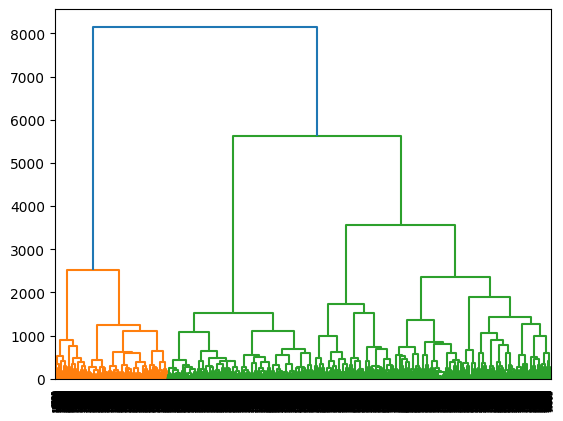

In [15]:
Z = linkage(r_df_tot[r_df_tot.columns.values[~(r_df_tot.isna().sum(axis=0) > 0).values]], 'ward')
cluster_order = np.array([int(item) for item in dendrogram(Z)["ivl"]])
cluster_order = pd.Series(list(range(r_df_tot.shape[0])),
    index=r_df_tot.index.values[cluster_order])
gene_clusters = pd.Series(fcluster(Z, 4, depth=10),
    index=r_df_tot.index.values[cluster_order])

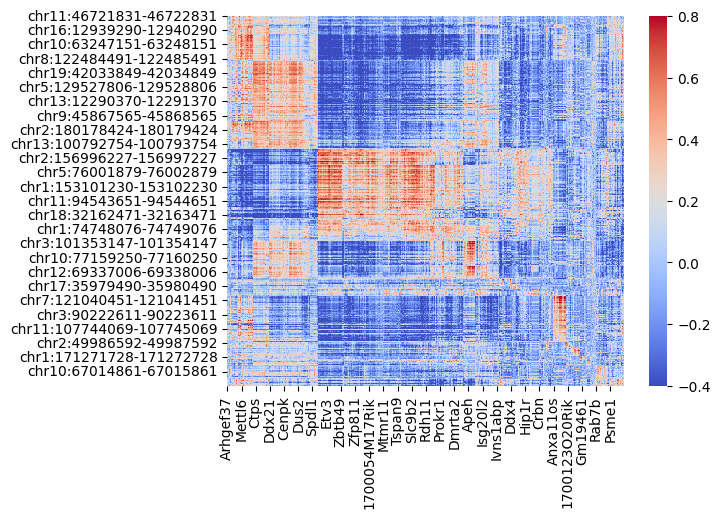

In [33]:
# r_df_gene_clusters, p_df_gene_clusters = marker_finder(r_df_tot.loc[gene_clusters.index.values], gene_clusters)

marker_df = pd.DataFrame({\
        "peak": r_df_gene_clusters.index.values,
        "r": r_df_gene_clusters.max(axis=1),
        "gene_cluster": r_df_gene_clusters.idxmax(axis=1)},
    index=r_df_gene_clusters.index.values).dropna(axis=0).sort_values(by=["gene_cluster", "r"], 
        ascending=[True, False])


sns.heatmap(\
    r_df_tot.loc[cluster_order.index.values, marker_df["peak"].values].T,
    cmap="coolwarm", vmax=0.8, vmin=-0.4)

plt.savefig("output/correlate_tea_atac_to_cite_rna_across_r7_clusters/"\
    "peak_to_gene_correlation_within_tads/"\
    "heatmap_peak_to_gene_correlations_top_10k_variable_genes.png",
    dpi=600)


In [34]:
# Write out the significant connections as a dataframe
sig_conns_df.to_csv("output/correlate_tea_atac_to_cite_rna_across_r7_clusters/"\
    "peak_to_gene_correlation_within_tads/sig_conns_df.csv", 
    header=True, index=True, index_label="peak")

In [35]:
# Write out the gene clusters and associations with peaks
gene_cluster_anno = pd.DataFrame({\
    "gene": cluster_order.index.values,
    "cluster": gene_clusters.loc[cluster_order.index.values].values})
gene_cluster_anno.to_csv("output/correlate_tea_atac_to_cite_rna_across_r7_clusters/"\
    "peak_to_gene_correlation_within_tads/gene_clusters.csv", 
    header=True, index=False)

marker_df.to_csv("output/correlate_tea_atac_to_cite_rna_across_r7_clusters/"\
    "peak_to_gene_correlation_within_tads/sig_conns_peak_assigned_to_gene_clusters.csv", 
    header=True, index=False)
